In [4]:
import numpy as np
from matplotlib import pyplot as plt

import pickle as pkl
from matplotlib import style
import jax.numpy as jnp
from jax import jacfwd, jit,grad
from functools import partial


from Robot import Robot
from virtual_sensor import virtual_sensor
from utils.DynamicFilters import getDynamicFilter
from utils.FIMPathPlanning import FIM_ascent_path_planning 
from utils.dLdp import dLdp
from utils.regions import CircleExterior
from tracking_log import logger

style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## System Communication Schema


![System Communication Schema](Schema.png)


In [5]:
def plot_err(ax,log,color = 'k',name = None):
    for key,est_locs in log['est_locs_log'].items():
        if key in["ekf"]:            
            target_locs = log['src_locs']['source_1']
            l = np.min([len(target_locs),len(est_locs)])
            target_locs = target_locs[:l]
            est_locs = est_locs[:l]
            target_locs = target_locs[~(np.isnan(est_locs))].reshape(-1,2)
            est_locs = est_locs[~(np.isnan(est_locs))].reshape(-1,2)
            
            if len(est_locs)>0:
                err = np.linalg.norm(est_locs-target_locs,axis = 1)
                if name is None:
                    ax.plot(err,color = color,label = r'$||q-\hat{q}||$',linestyle = 'dashed')
                else:
                    ax.plot(err,color = color,label = name)
#     ax.set_title('Est. Error vs Time steps',fontsize=15)
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Error',color = color)
    ax.legend(loc='upper center')
def plot_trajectory(ax,traj,name,marker,size=50):
    def direction_at(i):
        direction = traj[i+1,:]-traj[i,:]
        return traj[i,0],traj[i,1], direction[0],direction[1]

    ax.scatter(traj[:,0],traj[:,1],label=name,marker=marker,s = size)
	


    
def plot_dist_to_source(ax,log):
    target_locs = log['src_locs']['source_1']
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(target_locs)])
        dist = np.linalg.norm(sensor_locs[:l]-target_locs[:l],axis = 1)
        ax.plot(dist,label = key)
    ax.set_title('Sensor-Source Distance vs Time steps',fontsize=15)
    ax.set_xlabel('Time Steps')
#     ax.legend()
    
def plot_L(ax,log):
    q = log['src_locs']['source_1']
    ps = []
    for key,sensor_locs in log['sensor_locs'].items():
        l = np.min([len(sensor_locs),len(q)])
        ps.append(sensor_locs[:l])
    ps = np.hstack(ps).reshape(-1,3,2)
    Ls = [f_L(q[i,:],ps[i,:]) for i in range(l)]
    ax.plot(np.log(Ls),label = r'$\log(L(p,q))$')
    
    for key,qhat in log['est_locs_log'].items():
        if key in["ekf"]:            
            Lhat = [f_L(qhat[i,:],ps[i,:]) for i in range(l)]
            ax.plot(np.log(Lhat),label = r'$\log(L(p,qhat))$')
      
    ax.legend(loc='lower right')
#     ax.set_title('log(L(ps,q)) vs Time steps',fontsize=15)
    ax.set_ylabel('log loss')

def plot_all(log,main_title,save_file_name):
    fig = plt.figure(dpi=100,figsize=(10,15))
    gs = fig.add_gridspec(3,3,height_ratios = [2,1,1])

    
    ax = fig.add_subplot(gs[0,:2])
    
#     circle = plt.Circle((6, 6), 4, color='b', fill=False,label='Restricted Motion Boundary'\
#                         ,linewidth=10,linestyle='dashed')
#     ax.add_artist(circle)
    
    plot_experiment(ax,log)
    
    for key,val in log['est_locs_log'].items():
        if key in["ekf"]:
            val = val[~(np.isnan(val))].reshape(-1,2)
            if len(val)>0:
                ax = fig.add_subplot(gs[1,:])
                plot_err(ax,log)
            else:
                pass
    fig.suptitle(main_title,fontsize=20)
    
    fig.tight_layout()

    plt.savefig(save_file_name,bbox_inches='tight')


# animation function. This is called sequentially
def plot_experiment(ax,log):
#     ax.clear()

#     ax.set_xlim((0,7.5))
#     ax.set_ylim((1,10))

    ax.set_aspect('equal',adjustable='box')
           
    
    for key,val in log['src_locs'].items():
        plot_trajectory(ax,val,'Static Source','*',size = 400)

    for key,val in log['sensor_locs'].items():
        plot_trajectory(ax,val,key,'.',size=200)
    for key,val in log['est_locs_log'].items():
        if key in["ekf"]:
            val = val[~(np.isnan(val))].reshape(-1,2)
            if len(val)>0:

                plot_trajectory(ax,val,"EKF Estimation",'.',size=200)

                plot_trajectory(ax,val[:1,:],'Initial Guess','*',size = 200)

    ax.legend(loc='right',bbox_to_anchor=(1,0.05,0.5,1),ncol=1,fontsize=20,mode = 'expand',frameon=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    

## Main Loop 

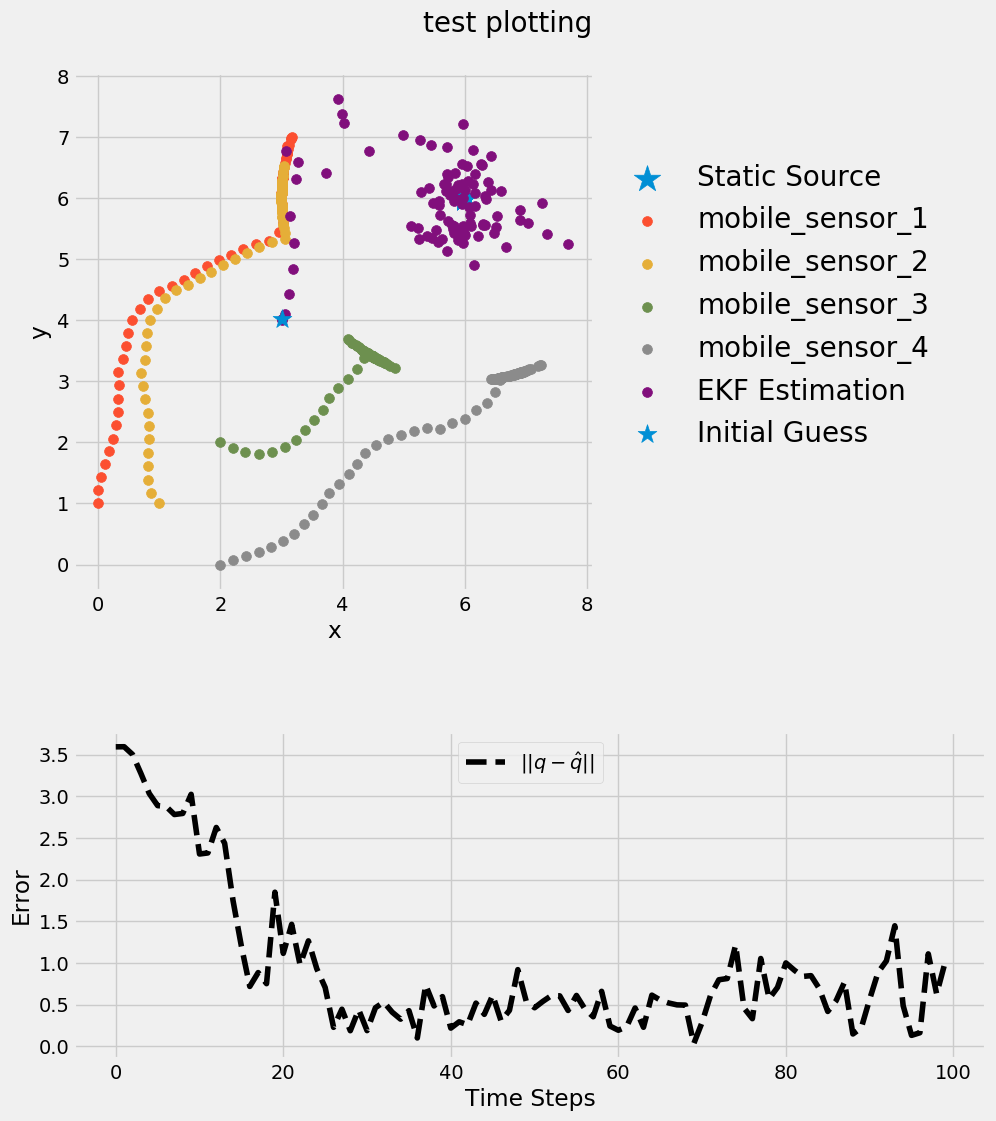

In [18]:
# Set up mobile sensors and sources
initial_locs = [[0,1.],[1,1.],[2.,2],[2,0]]
sensor_names = ["mobile_sensor_{}".format(i+1) for i in range(len(initial_locs))]
mobile_sensors = [Robot(loc,name) for loc,name in zip(initial_locs,sensor_names)]

src_locs = [[6.,6]]
src_names = ["source_{}".format(i+1) for i in range(len(src_locs))]
source = [Robot(loc,name) for loc,name in zip(src_locs,src_names)]

# Set up virtual sensors
C1=0
C0=0
k=1
b=-2
std = 0.1
vs = virtual_sensor(C1,C0,b,k,std)

# Set up location estimator
n_sen = len(mobile_sensors)
n_src = len(source)

C1s=C1*np.ones(n_sen)
C0s = C0*np.ones(n_sen)
ks = k * np.ones(n_sen)
bs = b*np.ones(n_sen)
initial_guess = np.array([3.,4.])
xlim = (-np.inf,np.inf)
ylim = (-np.inf,np.inf)

estimator = getDynamicFilter(len(mobile_sensors),len(source),C1s,C0s,ks,bs,initial_guess,filterType="ekf",xlim=xlim,ylim=ylim)
estimator_name = 'ekf'


# Set up waypoint planner
f_dLdp=dLdp(C1s=C1s,C0s=C0s,ks=ks,bs=bs)
planning_timesteps = 1
max_linear_speed = 0.22
planning_dt = 1
epsilon = 0.1
# The FIM waypoint planning  
fplan = lambda qs,ps:FIM_ascent_path_planning(f_dLdp,qs,ps,n_sen,\
                planning_timesteps,\
                max_linear_speed,\
                planning_dt,\
                epsilon,\
                # Rect2D(self.xlim,self.ylim))
                CircleExterior(np.array([6,6]),3))

# Set up data logger
log = logger(sensor_names,src_names)

# Enter main loop

N = 100
for _ in range(N):
    # Measure
    ps = np.array([r.loc for r in mobile_sensors])
    qs = np.array([s.loc for s in source])
    y = vs.measurement(qs,ps)

    # Estimate
    qhat = estimator.update_and_estimate_loc(ps,y)
    
        
     # Record
    for s in source:
        log.est_locs_log[estimator_name].append(qhat)
        log.src_locs[s.name].append(s.loc)
   
    for m in mobile_sensors:
        log.sensor_locs[m.name].append(m.loc)
  
         
    #Plan 
    waypoints = fplan(qhat,ps)
    
    # Move
    for i in range(n_sen):
        mobile_sensors[i].update_loc(waypoints[0][i])
    

# Plotting
main_title='test plotting'
save_file_name = 'test.png'
record = log.export()
plot_all(record,main_title,save_file_name)
